# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.


### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [ ]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [ ]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[TO COMPLETE]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
      
        z_mean, z_var = inputs
        
        e = tf.keras.backend.random_normal(tf.shape(z_var))
        return z_mean + keras.backend.exp(z_var/2)*e

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. Insert motivations about your choice into the tex cell below.

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))

x = keras.layers.Dense(512, activation='relu')(encoder_inputs)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
z_mean =  keras.layers.Dense(latent_dim, activation = 'linear')(x)     #[TO COMPLETE] Hint: size would be = latent_dim
z_var =  keras.layers.Dense(latent_dim, activation = 'linear')(x)       #[TO COMPLETE] Hint: size would be = latent_dim

z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          65664       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                            

**Answer:**
I found 3 as the optimal number of layers. I opted for the 512, 128, 64 layers size in order to let the encoder be able to learn only the most significative informations of the data. I used the relu activation function because non-linearity allows the encoder to learn as much useful information as it can and it's also useful to prevent vanishing gradient problems. For the computation of the z_mean and z_var I chose the linear activation function so the activation values are not changed.

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: Define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = keras.layers.Dense(64, activation='relu')(latent_inputs)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(512, activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation = 'sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 512)               66048     
                                                                 
 dense_8 (Dense)             (None, 784)               402192    
                                                                 
Total params: 476,752
Trainable params: 476,752
Non-trainable params: 0
_________________________________________________________________


**Answer:**

Since we are doing a encoder-decoder architecture, the decoder has the same but reversed structure of the encoder (same number of layers/units but opposite order). The final activation function is a sigmoid since we need the pixels in output to have the same range of possible values of the input pixels, so from 0 to 1 (because it was normalized /255).

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction)))
            kl_loss = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
          
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 6s 7ms/step - loss: 33.9578 - reconstruction_loss: 32.8400 - kl_loss: 1.1178
Epoch 2/30
469/469 [==============================] - 3s 7ms/step - loss: 30.2665 - reconstruction_loss: 27.9936 - kl_loss: 2.2729
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 29.4449 - reconstruction_loss: 26.6639 - kl_loss: 2.7810
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 28.9152 - reconstruction_loss: 25.8258 - kl_loss: 3.0894
Epoch 5/30
469/469 [==============================] - 3s 7ms/step - loss: 28.6375 - reconstruction_loss: 25.3472 - kl_loss: 3.2902
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 28.4206 - reconstruction_loss: 24.9719 - kl_loss: 3.4487
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 28.2278 - reconstruction_loss: 24.6430 - kl_loss: 3.5848
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 28.0467 -

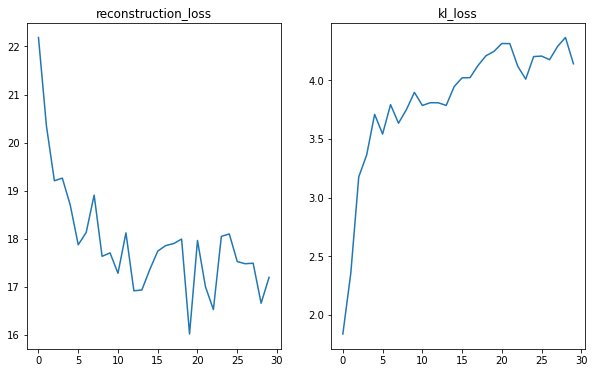

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

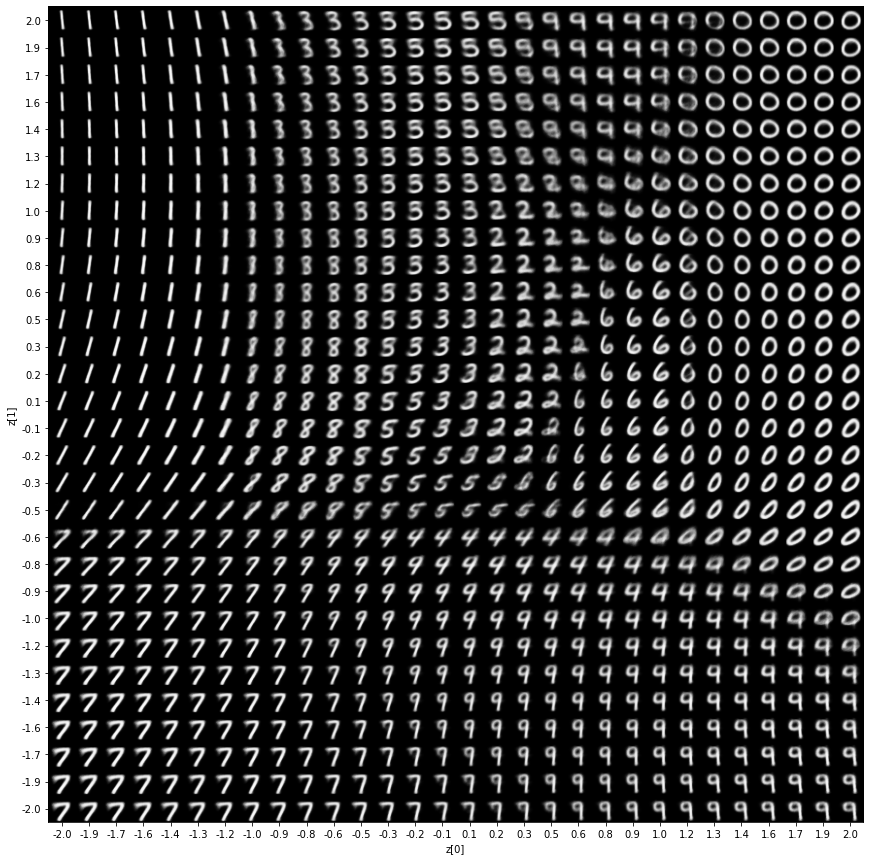

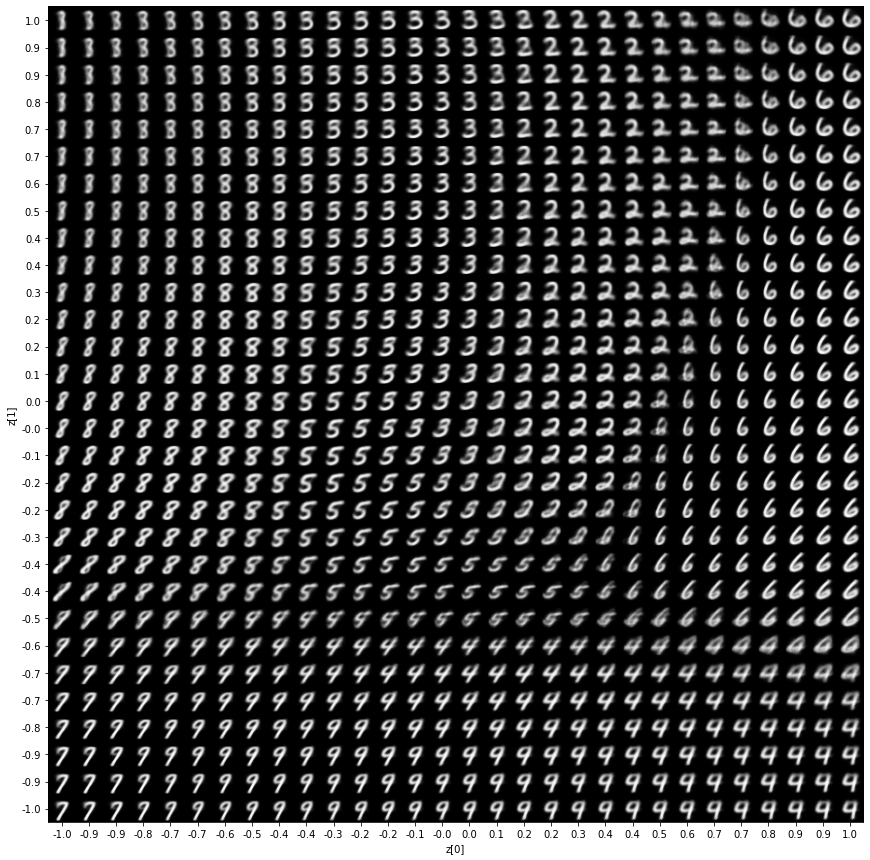

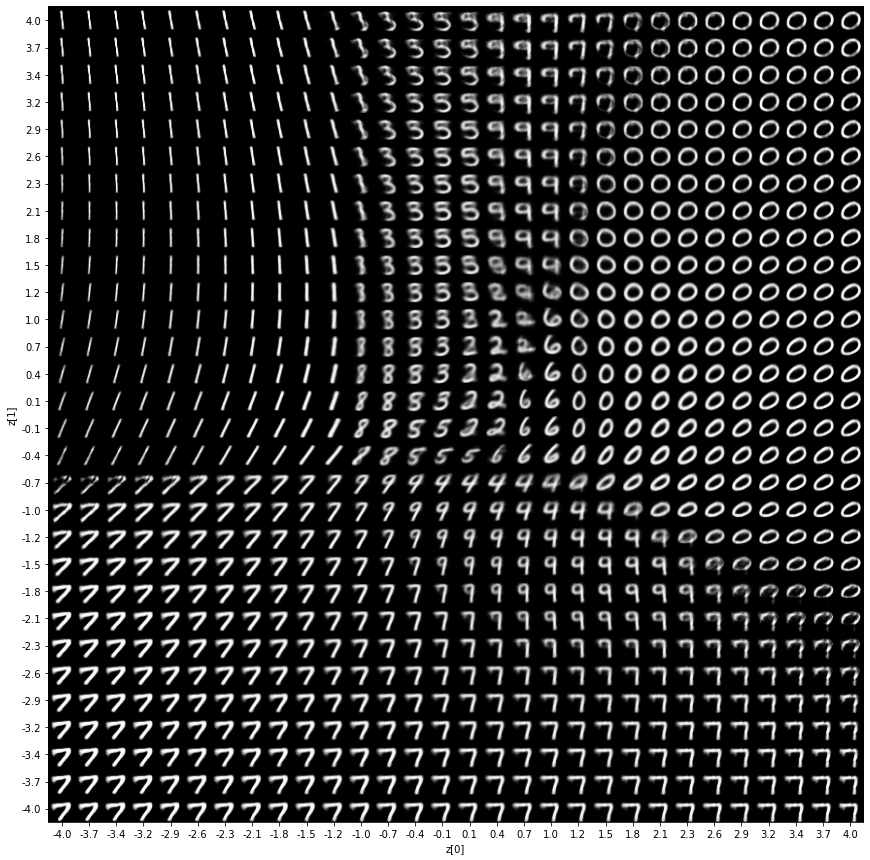

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore what happens with different "scales"

for i in [1, 4]:
  plot_latent(encoder, decoder, i, 30) 

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

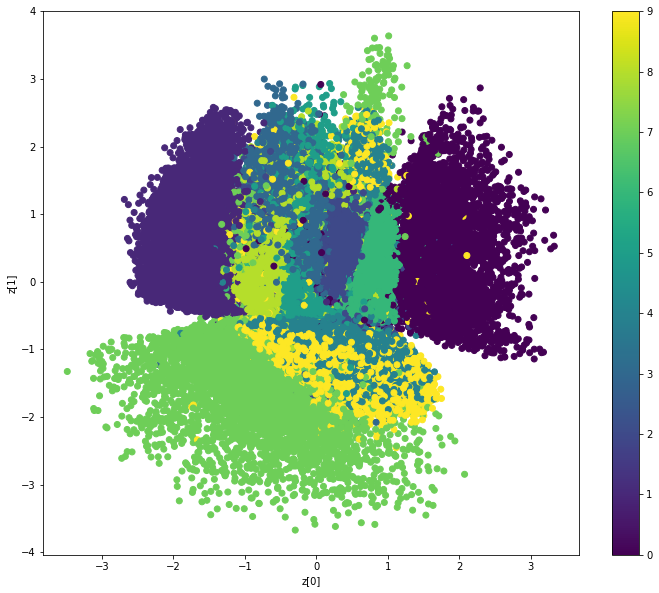

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**Answer:**

By changing the 'scale' value we get different plots: with an higher scale we see all the digits, with a lower scale we can see only a subset of all the digits.

As we can see from the plot above, my VAE can identify well the digits (7,0,1), can quite good identify (3,9) and is a little bit messy with (2,4,5,6,8). Anyway, this model is the best that I could find. During the modelling I saw that increasing the number of layers and units led the model to learn more significantive features of the digits since it was a more complex model.

I tried different non-linear activation functions and I found that tahn and ReLu were the better ones, since they are good for preventing vanishing gradient problems. They both got similar results so I chose to use ReLU.